This notebook shows an example of how to run the optimization for a given model and grayscale image. 

In [1]:
import torch
from tqdm import tqdm
from functools import partial
from torch.utils.data import DataLoader

from autoencoder import Network
from datasets import BinarizedVOCDataset, GAUSSIAN_BLUR, HumanDataset
from optimization import mse_loss, get_latent_space_sampler, calcLatentSpaceNormAndMean, get_optimal_mooney_given_grayscale
from training import get_device, set_seeds
from utils.persistance import load_model
from utils.plotting import view_images, plot_optimization_loss

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Setup

- Loading configs to run a optimization over the best BCE or MSE models

In [2]:
set_seeds(seed=0)

train_dataset = BinarizedVOCDataset(image_set = 'train', download =False, augmentations = GAUSSIAN_BLUR )
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

In [3]:
device  = get_device()
configs = {'BCE': {'filename': '../models/model_v1_drop_p_0.3_BCE_thres_0.0_Adam_LR_0.001_s_0_1702270054_5.pth', 'pred_threshold': .5}, 
           'MSE': {'filename': '../models/model_v1_drop_p_0.3_MSE_thres_0.5_Adam_LR_0.001_s_0_1702280403_5.pth', 'pred_threshold': .5}, 
        }

for key in configs.keys():
    model, model_dict = load_model( Network, 
                                    model_filename = configs[key]['filename'], 
                                    device         = device, 
                                    freeze         = True )

    for p in model.parameters():
        assert not p.requires_grad

    mean_latent, std_latent = calcLatentSpaceNormAndMean(model.encode, train_loader)

    configs[key]['model']       = model
    configs[key]['mean_latent'] = mean_latent
    configs[key]['std_latent']  = std_latent

In [5]:
experiments = {} # Collect experiments if running many
N           = 1  # Number of dataset images to use
iterations  = 1000
lr          = .1
optim_loss  = 'MSE'
human_ds    = HumanDataset() 

# Example of optimization for single grayscale image

- In this section we run the optimization for 1 image (using MSE and the BCE model)
- We print every ten iterations the state to show the incremental improvement. 
- In every visualization, we see:
    - Left: grayscale image from human dataset for which we are trying to generate the Mooney
    - Middle: output of the model - pixel intensities or logits depending on how the autoencoder model was trained (MSE or BCE respectively)
    - Right: actual prediction of autoencoder (ie output transformed to 0s and 1s)

## Run Optimization for best MSE autoencoder model

 10%|▉         | 99/1000 [00:16<02:30,  6.00it/s]

Run Id MSE-Adam0.1-Threshold.5-Loss.MSE-Img-0 - Loss: 0.0036281514912843704	Accuracy: 0.9105682373046875


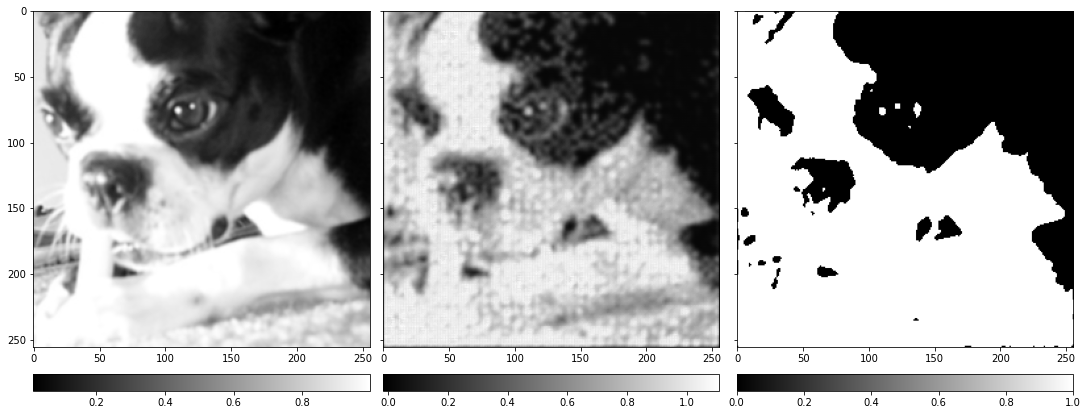

 20%|█▉        | 199/1000 [00:33<02:04,  6.42it/s]

Run Id MSE-Adam0.1-Threshold.5-Loss.MSE-Img-0 - Loss: 0.002441585063934326	Accuracy: 0.9113311767578125


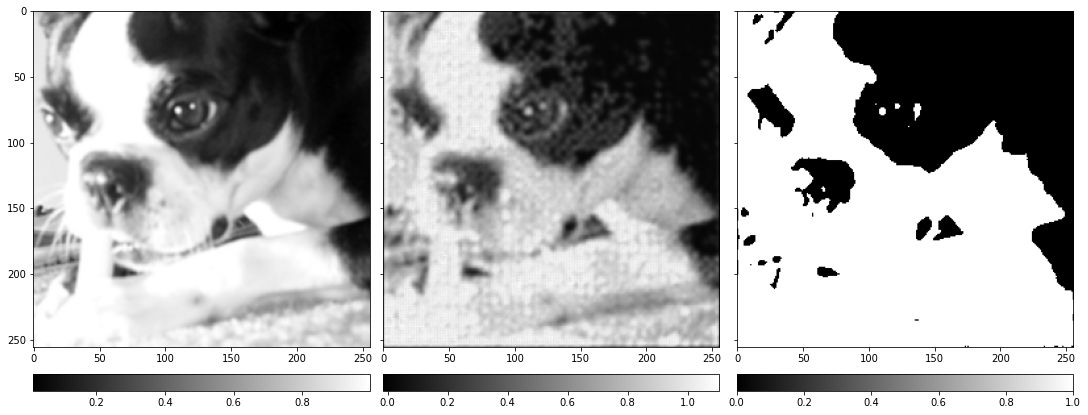

 30%|██▉       | 299/1000 [00:50<01:52,  6.23it/s]

Run Id MSE-Adam0.1-Threshold.5-Loss.MSE-Img-0 - Loss: 0.00200211931951344	Accuracy: 0.9116058349609375


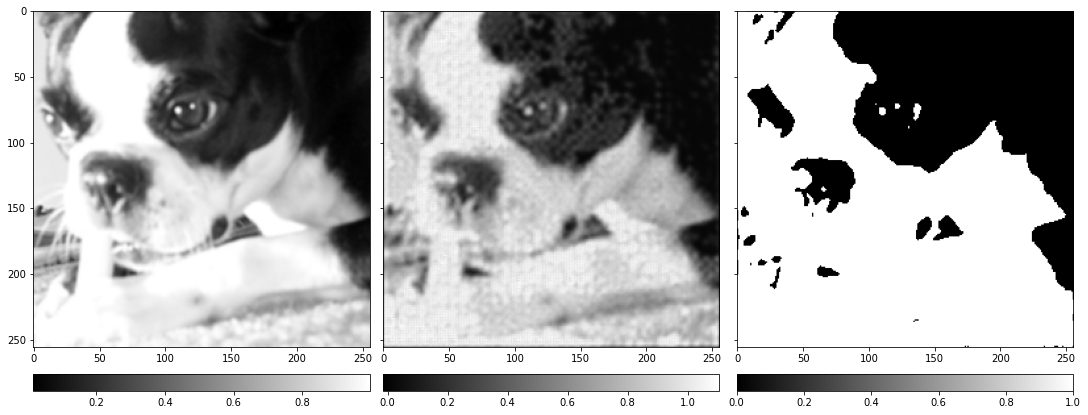

 40%|███▉      | 399/1000 [01:07<01:42,  5.87it/s]

Run Id MSE-Adam0.1-Threshold.5-Loss.MSE-Img-0 - Loss: 0.0017576073296368122	Accuracy: 0.9120941162109375


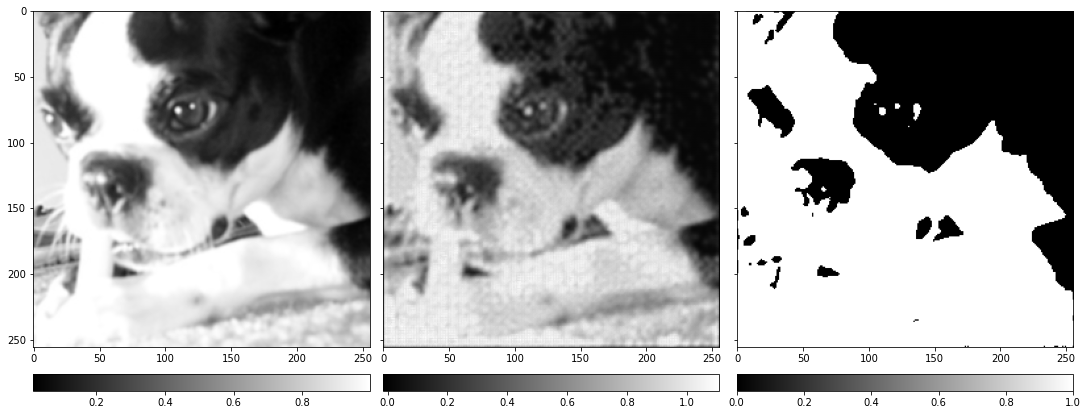

 50%|████▉     | 499/1000 [01:24<01:13,  6.82it/s]

Run Id MSE-Adam0.1-Threshold.5-Loss.MSE-Img-0 - Loss: 0.0015991779509931803	Accuracy: 0.912139892578125


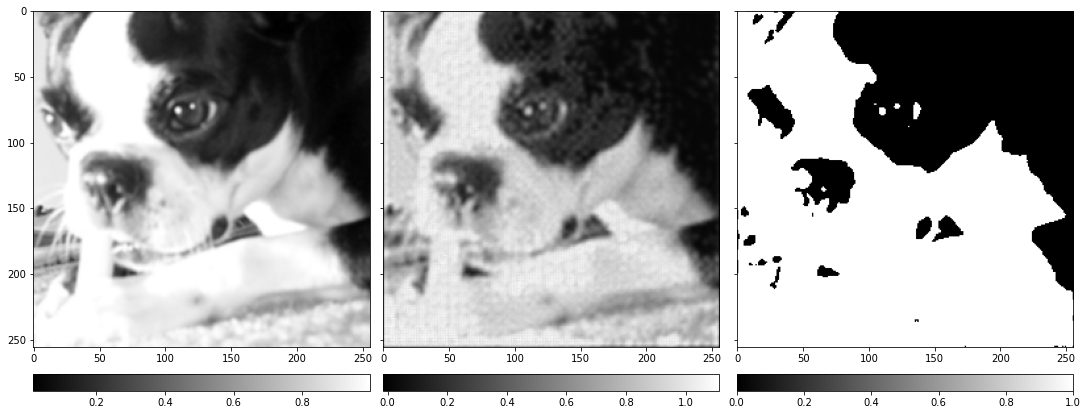

 60%|█████▉    | 599/1000 [01:41<01:04,  6.22it/s]

Run Id MSE-Adam0.1-Threshold.5-Loss.MSE-Img-0 - Loss: 0.0014909354504197836	Accuracy: 0.91217041015625


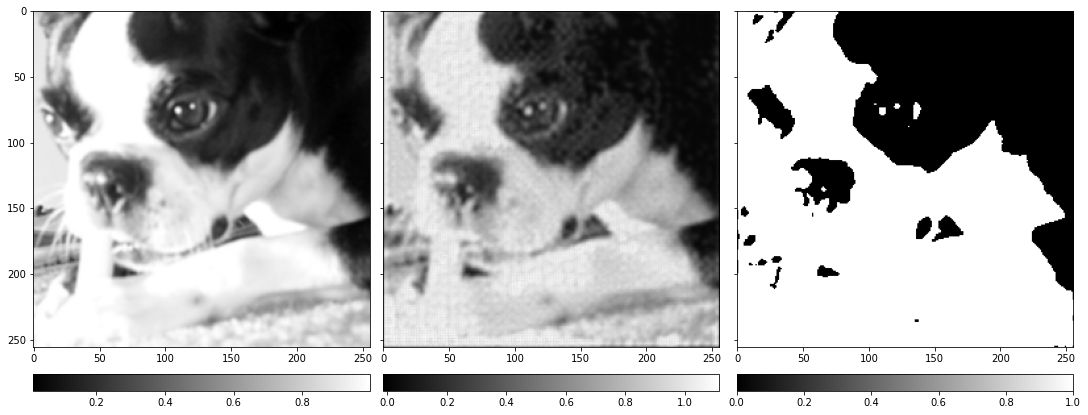

 70%|██████▉   | 699/1000 [01:58<00:46,  6.53it/s]

Run Id MSE-Adam0.1-Threshold.5-Loss.MSE-Img-0 - Loss: 0.001407680450938642	Accuracy: 0.9122467041015625


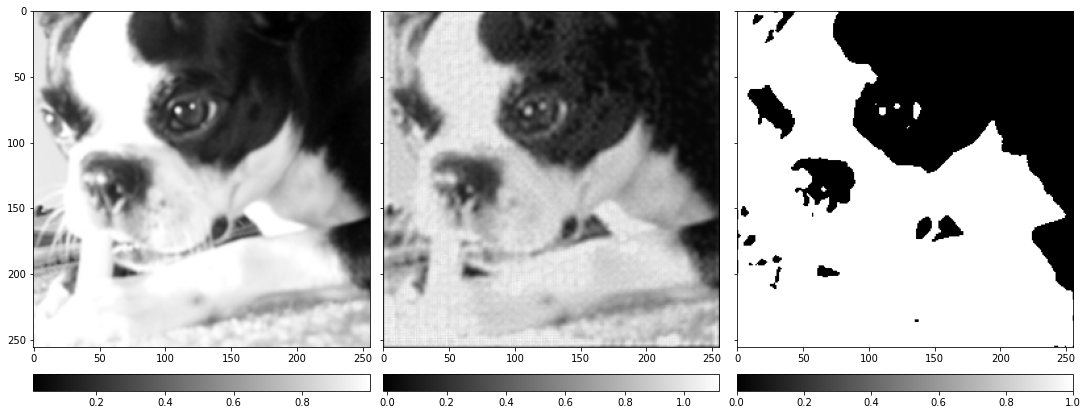

 80%|███████▉  | 799/1000 [02:15<00:32,  6.19it/s]

Run Id MSE-Adam0.1-Threshold.5-Loss.MSE-Img-0 - Loss: 0.00134479277767241	Accuracy: 0.91229248046875


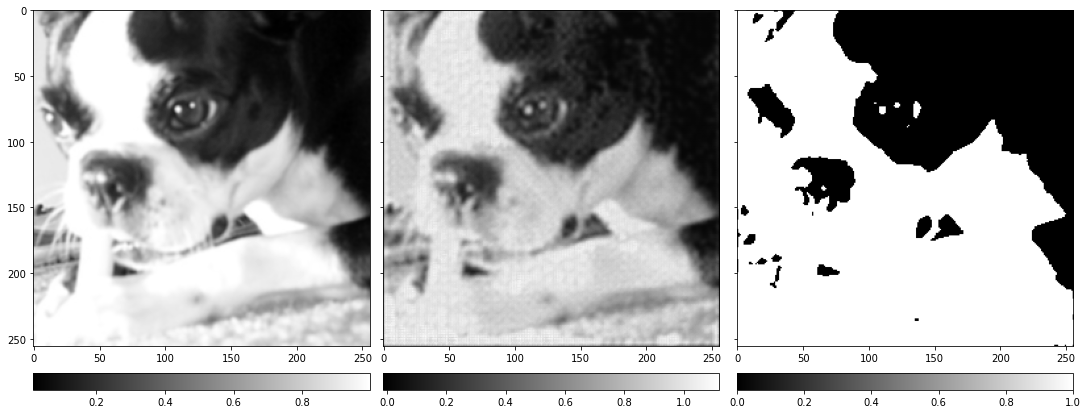

 90%|████████▉ | 899/1000 [02:33<00:15,  6.34it/s]

Run Id MSE-Adam0.1-Threshold.5-Loss.MSE-Img-0 - Loss: 0.0012911087833344936	Accuracy: 0.9123687744140625


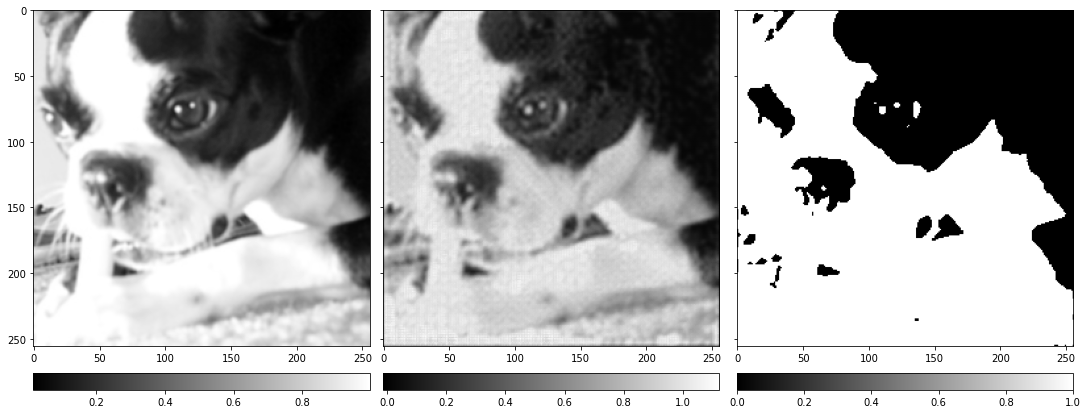

100%|█████████▉| 999/1000 [02:51<00:00,  6.00it/s]

Run Id MSE-Adam0.1-Threshold.5-Loss.MSE-Img-0 - Loss: 0.0012461855076253414	Accuracy: 0.912506103515625


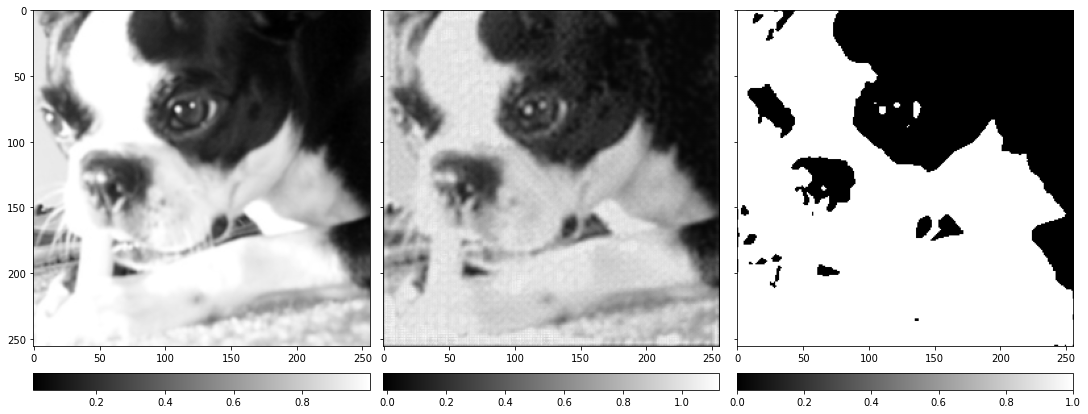

100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


In [6]:
set_seeds(seed=0)

exp_key     = f'MSE-Adam{lr}-Threshold.5-Loss.{optim_loss}'
config_key  = 'MSE' 
model, pred_threshold, mean_latent, std_latent =  configs[config_key]['model'], configs[config_key]['pred_threshold'],configs[config_key]['mean_latent'], configs[config_key]['std_latent']

experiments[exp_key] = []

for sample_idx in range(N):
    gray_img, mooney_img = human_ds[sample_idx]
    hidden               = get_latent_space_sampler(mean_latent=mean_latent, std_latent=std_latent).sample()
    hidden.requires_grad_()
    optimizer     = torch.optim.Adam([hidden], lr = lr) 

    best_hidden, best_mooney, losses, accuracies = get_optimal_mooney_given_grayscale(
                                                                        gray_img         = gray_img, 
                                                                        eval_img         = mooney_img,     # Only used to report evaluation (accuracy) against a real mooney
                                                                        hidden           = hidden, 
                                                                        generator_fn     = model.decode, 
                                                                        pred_threshold   = pred_threshold, # Should depends on whether model outputs are logits or pixel intensities 
                                                                        loss_fn          = mse_loss,
                                                                        loss_embeddings  = None, 
                                                                        optimizer        = optimizer,
                                                                        iterations       = iterations,
                                                                        show_images_n    = 100, 
                                                                        run_id           = f"{exp_key}-Img-{sample_idx}")
 
    experiments[exp_key].append((best_hidden, best_mooney, losses, accuracies))

## Run Optimization for best MSE autoencoder model

 10%|▉         | 99/1000 [00:18<02:23,  6.26it/s]

Run Id BCE-Adam0.1-Threshold.0-Loss.MSE-Img-0 - Loss: 0.11001259833574295	Accuracy: 0.8268280029296875


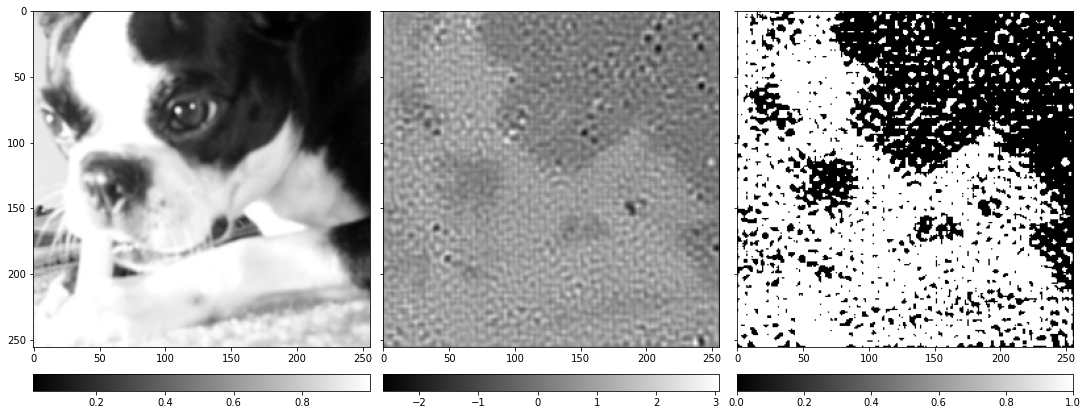

 20%|█▉        | 199/1000 [00:36<02:07,  6.28it/s]

Run Id BCE-Adam0.1-Threshold.0-Loss.MSE-Img-0 - Loss: 0.040768373757600784	Accuracy: 0.888519287109375


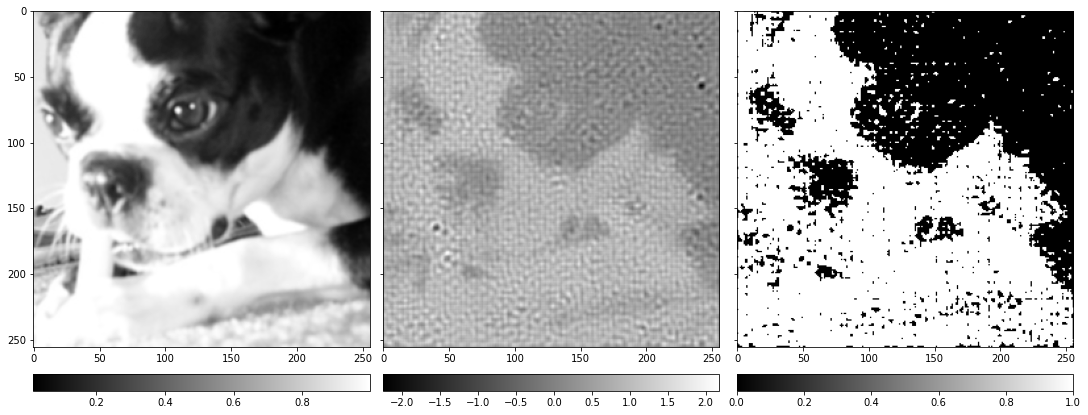

 30%|██▉       | 299/1000 [00:54<01:58,  5.93it/s]

Run Id BCE-Adam0.1-Threshold.0-Loss.MSE-Img-0 - Loss: 0.027767866849899292	Accuracy: 0.902191162109375


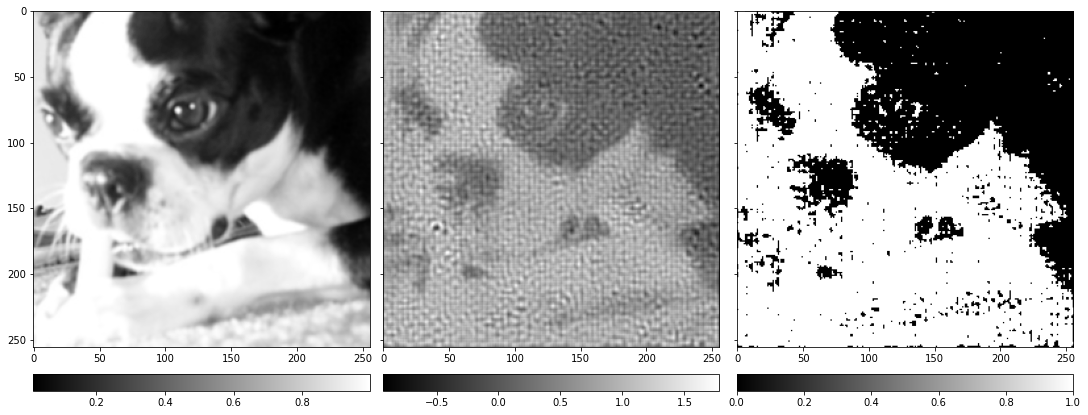

 40%|███▉      | 399/1000 [01:14<01:56,  5.16it/s]

Run Id BCE-Adam0.1-Threshold.0-Loss.MSE-Img-0 - Loss: 0.02231784164905548	Accuracy: 0.90679931640625


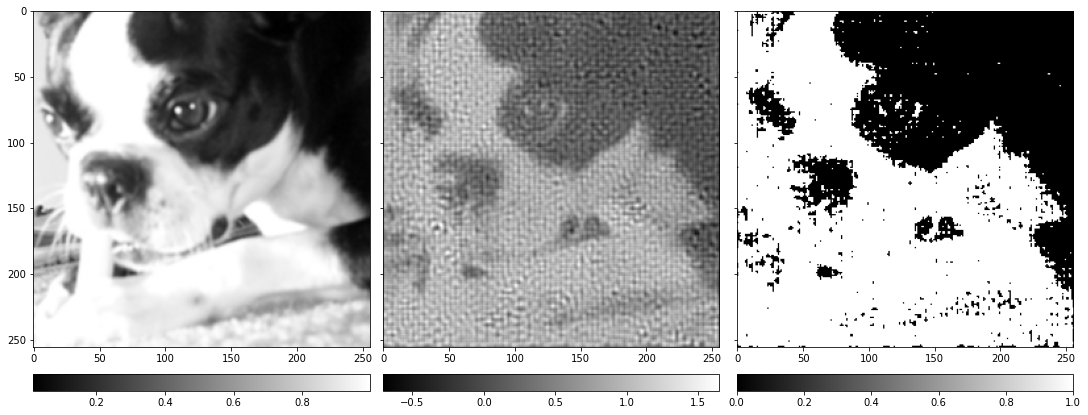

 50%|████▉     | 499/1000 [01:33<01:35,  5.25it/s]

Run Id BCE-Adam0.1-Threshold.0-Loss.MSE-Img-0 - Loss: 0.019187211990356445	Accuracy: 0.9097137451171875


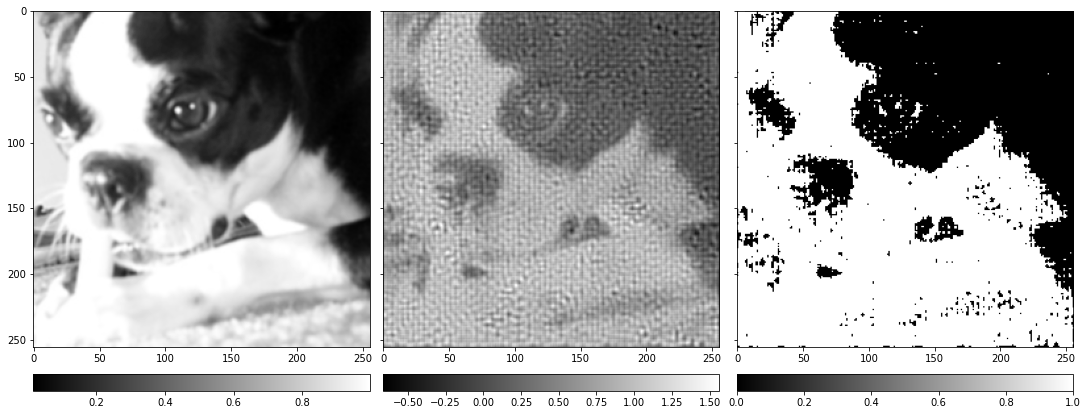

 60%|█████▉    | 599/1000 [01:51<01:07,  5.98it/s]

Run Id BCE-Adam0.1-Threshold.0-Loss.MSE-Img-0 - Loss: 0.017072279006242752	Accuracy: 0.91082763671875


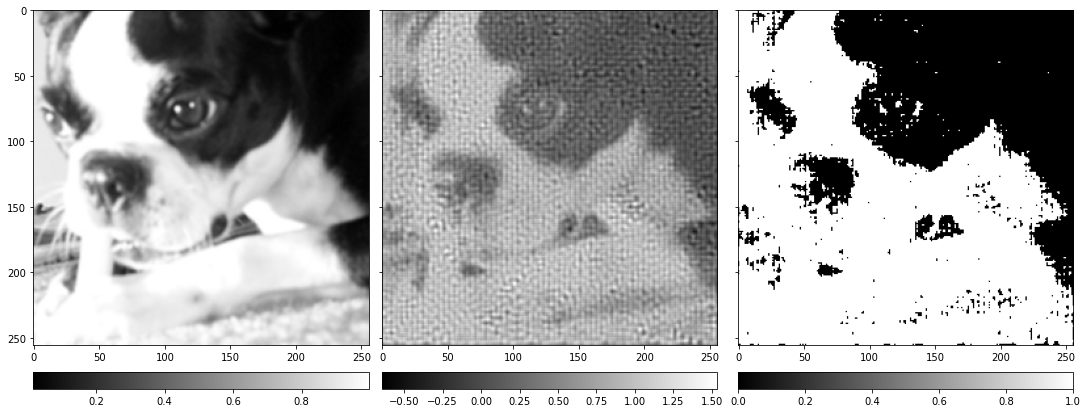

 70%|██████▉   | 699/1000 [02:09<00:52,  5.72it/s]

Run Id BCE-Adam0.1-Threshold.0-Loss.MSE-Img-0 - Loss: 0.015439299866557121	Accuracy: 0.9112091064453125


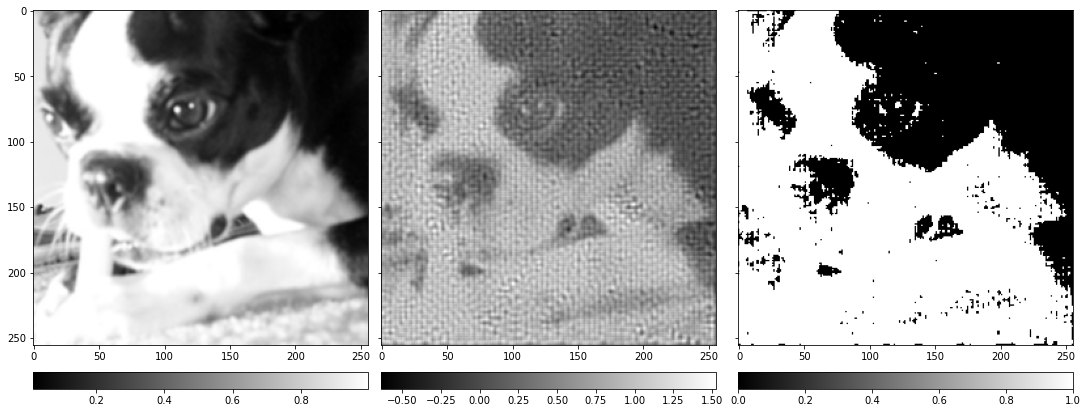

 80%|███████▉  | 799/1000 [02:28<00:34,  5.81it/s]

Run Id BCE-Adam0.1-Threshold.0-Loss.MSE-Img-0 - Loss: 0.014217088930308819	Accuracy: 0.9117279052734375


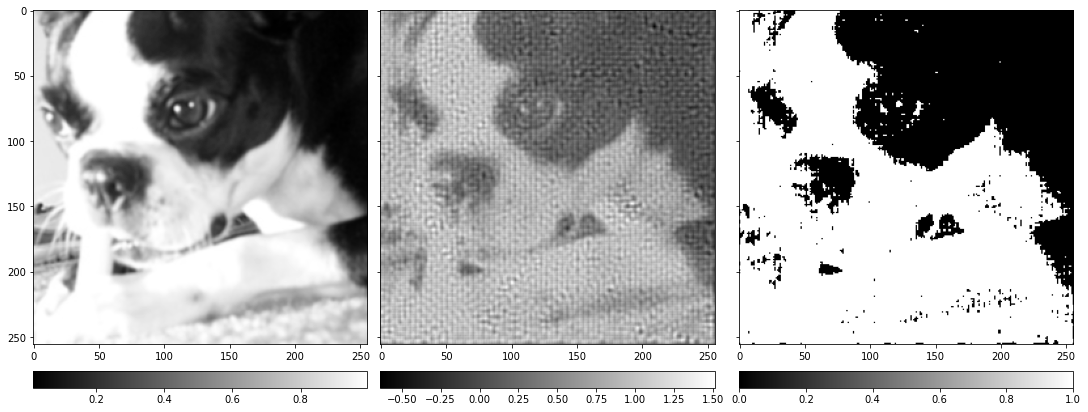

 90%|████████▉ | 899/1000 [02:48<00:18,  5.59it/s]

Run Id BCE-Adam0.1-Threshold.0-Loss.MSE-Img-0 - Loss: 0.01322195865213871	Accuracy: 0.9121856689453125


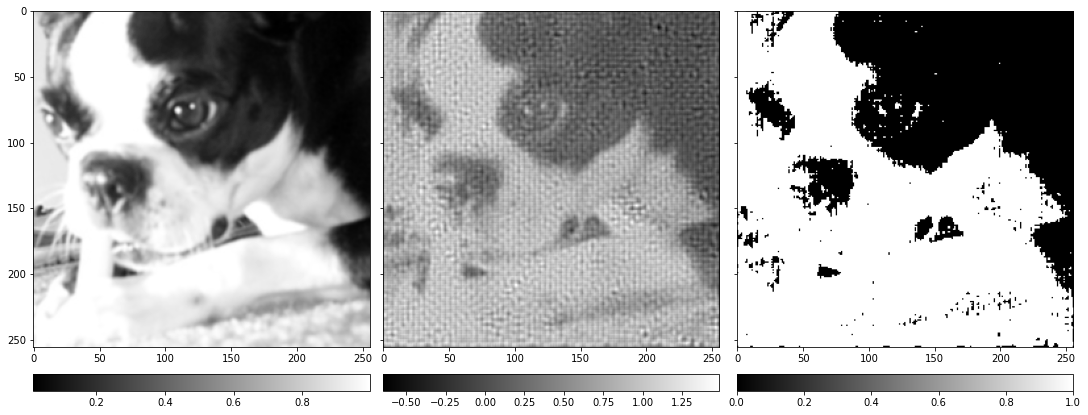

100%|█████████▉| 999/1000 [03:05<00:00,  5.72it/s]

Run Id BCE-Adam0.1-Threshold.0-Loss.MSE-Img-0 - Loss: 0.012407533824443817	Accuracy: 0.912872314453125


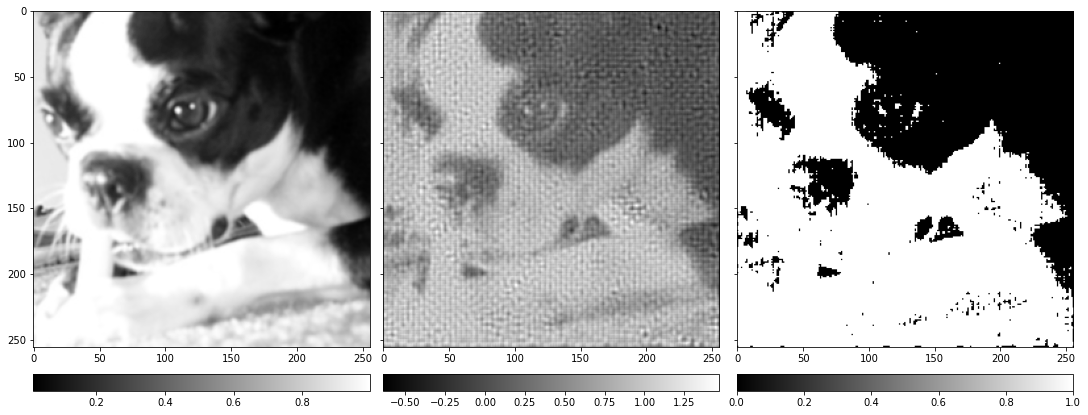

100%|██████████| 1000/1000 [03:06<00:00,  5.35it/s]


In [7]:
set_seeds(seed=0)

exp_key     = f'BCE-Adam{lr}-Threshold.0-Loss.{optim_loss}'
config_key  = 'BCE'
model, pred_threshold, mean_latent, std_latent =  configs[config_key]['model'], configs[config_key]['pred_threshold'],configs[config_key]['mean_latent'], configs[config_key]['std_latent']

experiments[exp_key] = []

for sample_idx in range(N):
    gray_img, mooney_img = human_ds[sample_idx]
    hidden               = get_latent_space_sampler(mean_latent=mean_latent, std_latent=std_latent).sample()
    hidden.requires_grad_()
    optimizer     = torch.optim.Adam([hidden], lr = lr) 

    best_hidden, best_mooney, losses, accuracies = get_optimal_mooney_given_grayscale(
                                                                        gray_img         = gray_img, 
                                                                        eval_img         = mooney_img,  # Only used to report evaluation (accuracy) against a real mooney
                                                                        hidden           = hidden, 
                                                                        generator_fn     = model.decode, 
                                                                        pred_threshold   = pred_threshold,          # Should depends on whether model outputs are logits or pixel intensities 
                                                                        loss_fn          = mse_loss,
                                                                        loss_embeddings  = None, 
                                                                        optimizer        = optimizer,
                                                                        iterations       = iterations,
                                                                        show_images_n    = 100, 
                                                                        run_id           = f"{exp_key}-Img-{sample_idx}")
 
    experiments[exp_key].append((best_hidden, best_mooney, losses, accuracies))